In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

data = tfds.load('tf_flowers')
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [61]:
train_data = data['train'].skip(600)
test_data = data['train'].take(600)

@tf.function
def build_data(data):
  cropped = tf.dtypes.cast(tf.image.random_crop(data['image'] / 255, (256, 256, 3)), tf.float32)
  lr = tf.image.resize(cropped, (128, 128))
  lr = tf.image.resize(lr, (256, 256), method = tf.image.ResizeMethod.BICUBIC)
  return (lr, cropped)

def downsample_image(image,scale):
  lr = tf.image.resize(image / 255, (image.shape[0]//scale, image.shape[1]//scale))
  lr = tf.image.resize(lr, (image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
  return lr

def upsample_image(image,scale):
  hr = tf.image.resize(image / 255, (image.shape[0] * scale, image.shape[1] * scale), method=tf.image.ResizeMethod.BICUBIC)
  hr = tf.image.resize(hr, (256, 256), method=tf.image.ResizeMethod.BICUBIC)
  return hr

In [62]:
train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
def show_image():
    for x in train_dataset_mapped.take(1):
      plt.imshow(x[0].numpy())
      plt.show()
      plt.imshow(x[1].numpy())
      plt.show()

In [64]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse = tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

SRCNN_915.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = pixel_mse_loss)

In [65]:
total_iterations = 20
for iteration in range(total_iterations):
    print(f"Iteration: {iteration + 1} / {total_iterations}")
    train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    val_dataset_mapped = test_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    SRCNN_915.fit(train_dataset_mapped, epochs = 1,validation_data = val_dataset_mapped)

Iteration: 1 / 20
24/24 [==============================] - 12s 354ms/step - loss: 0.0430 - val_loss: 0.0151
Iteration: 2 / 20
24/24 [==============================] - 8s 347ms/step - loss: 0.0113 - val_loss: 0.0090
Iteration: 3 / 20
24/24 [==============================] - 9s 354ms/step - loss: 0.0076 - val_loss: 0.0065
Iteration: 4 / 20
24/24 [==============================] - 9s 381ms/step - loss: 0.0061 - val_loss: 0.0055
Iteration: 5 / 20
24/24 [==============================] - 10s 420ms/step - loss: 0.0054 - val_loss: 0.0049
Iteration: 6 / 20
24/24 [==============================] - 10s 424ms/step - loss: 0.0049 - val_loss: 0.0047
Iteration: 7 / 20
24/24 [==============================] - 10s 413ms/step - loss: 0.0046 - val_loss: 0.0043
Iteration: 8 / 20
24/24 [==============================] - 10s 424ms/step - loss: 0.0043 - val_loss: 0.0042
Iteration: 9 / 20
24/24 [==============================] - 10s 425ms/step - loss: 0.0046 - val_loss: 0.0051
Iteration: 10 / 20
24/24 [=====

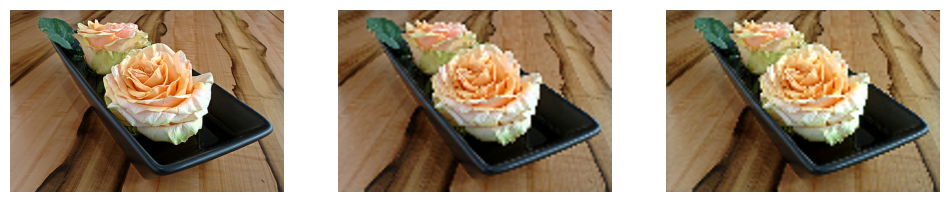

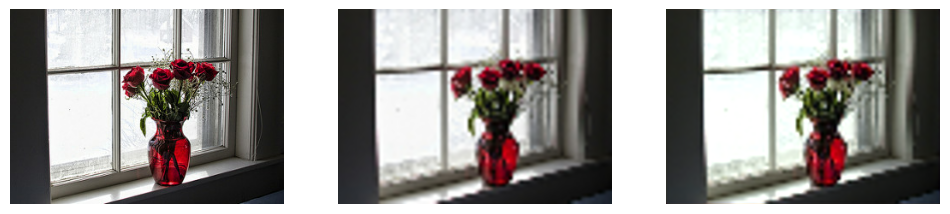

In [67]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(2):
  fig = plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.imshow(x['image'].numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr = downsample_image(x['image'].numpy(),4)
  plt.imshow(lr.numpy())  
  plt.axis('off')
  plt.subplot(1,3,3)
  pred = SRCNN_915(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')
  plt.show()

In [74]:
FSRCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 9, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(64, 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(3, 5, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2DTranspose(3, 2, padding = 'same', activation = 'relu')
])

FSRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [75]:
total_iterations = 20
train_data = data['train'].skip(600)
test_data = data['train'].take(600)
train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
for iteration in range(total_iterations):
    print(f"Iteration: {iteration + 1} / {total_iterations}")
    train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    val_dataset_mapped = test_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    FSRCNN.fit(train_dataset_mapped, epochs = 1,validation_data = val_dataset_mapped)

Iteration: 1 / 20
24/24 [==============================] - 18s 492ms/step - loss: 0.1033 - val_loss: 0.0448
Iteration: 2 / 20
24/24 [==============================] - 11s 465ms/step - loss: 0.0331 - val_loss: 0.0269
Iteration: 3 / 20
24/24 [==============================] - 11s 468ms/step - loss: 0.0257 - val_loss: 0.0242
Iteration: 4 / 20
24/24 [==============================] - 11s 472ms/step - loss: 0.0234 - val_loss: 0.0226
Iteration: 5 / 20
24/24 [==============================] - 12s 482ms/step - loss: 0.0223 - val_loss: 0.0214
Iteration: 6 / 20
24/24 [==============================] - 11s 477ms/step - loss: 0.0214 - val_loss: 0.0213
Iteration: 7 / 20
24/24 [==============================] - 12s 480ms/step - loss: 0.0201 - val_loss: 0.0194
Iteration: 8 / 20
24/24 [==============================] - 12s 481ms/step - loss: 0.0196 - val_loss: 0.0193
Iteration: 9 / 20
24/24 [==============================] - 12s 486ms/step - loss: 0.0190 - val_loss: 0.0184
Iteration: 10 / 20
24/24 [==

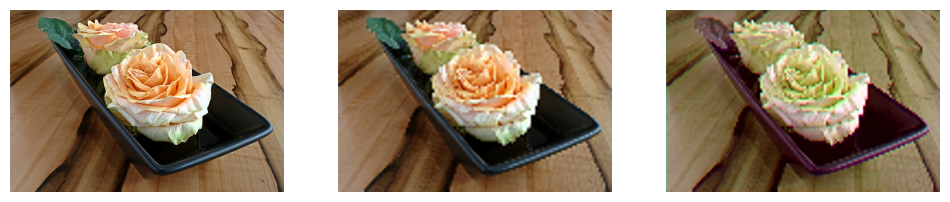

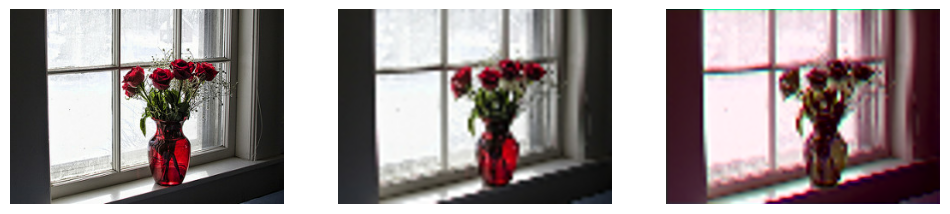

In [77]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(2):
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(x['image'].numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr = downsample_image(x['image'].numpy(),4)
  plt.imshow(lr.numpy())  
  plt.axis('off')
  plt.subplot(1,3,3)
  pred = FSRCNN(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')
  plt.show()